In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

In [2]:
keras.__version__

'2.11.0'

In [3]:
def print_progress(count, max_count):
   
    pct_complete = count / max_count

    
    msg = "\r- Progress: {0:.1%}".format(pct_complete)


    sys.stdout.write(msg)
    sys.stdout.flush()

In [4]:
train_dir = "data/Train"
test_dir = "data/test"

In [5]:
 
img_size = 299

img_size_touple = (img_size, img_size)


num_channels = 3


img_size_flat = img_size * img_size * num_channels


num_classes = 4


_images_per_file = 20



In [7]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    frames_list = []
    video_reader = cv2.VideoCapture(in_file)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    list = np.linspace(1, video_frames_count-2, _images_per_file, endpoint=True)
    skip_frames_window = max(int(video_frames_count/_images_per_file), 1)

    for frame_counter in list:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(frame_counter))
        
        success, frame = video_reader.read()

        if not success:
            break

        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
        frames_list.append(res)
    
    
    video_reader.release()
    resul = np.array(frames_list)
    
    resul = preprocess_input(resul)
    return resul

In [8]:
def label_video_names(in_dir):
    
    
    names = []
   
    labels = []
    
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'As':
                labels.append([0,0,0,1])
                names.append("Assault/"+file_name)
            elif file_name[0:2] == 'Ex':
                labels.append([0,0,1,0])
                names.append("Explosion/"+file_name)
            elif file_name[0:2] == 'No':
                labels.append([0,1,0,0])
                names.append("Normal/"+file_name)
            elif file_name[0:2] == 'Ro':
                labels.append([1,0,0,0])
                names.append("RoadAccidents/"+file_name)
                     
            
    c = list(zip(names,labels))

    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [9]:

train_names, train_labels = label_video_names(train_dir)
test_names, test_labels = label_video_names(test_dir)

In [10]:
len(test_names)

189

In [11]:
frames = get_frames(train_dir, train_names[89])

In [12]:
visible_frame = (frames*255).astype('uint8')
len(visible_frame)

20

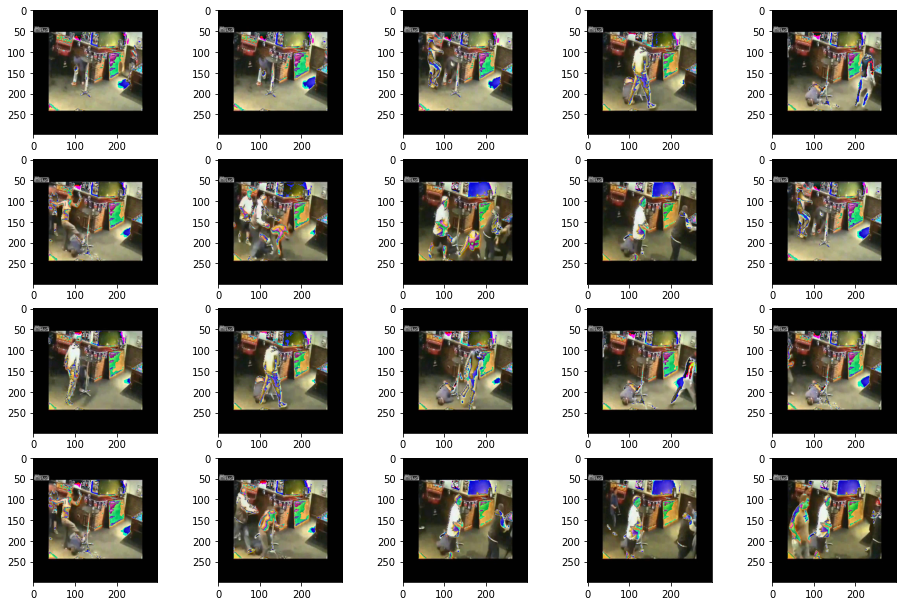

In [13]:
from matplotlib.pyplot import imshow
fig = plt.figure(figsize=(16,16))

for i,rand_indx in enumerate(visible_frame):
    ax = plt.subplot(6,5,i+1)
    
   
    plt.imshow(rand_indx)




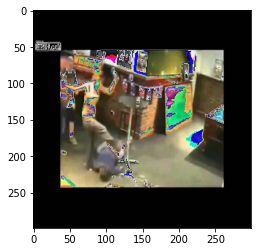

In [14]:
plt.imshow(visible_frame[15])

In [15]:
image_model = Xception( include_top=True, weights='imagenet')

In [16]:
image_model.summary()


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [17]:

transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (299, 299)
The output of the selecter layer of VGG16 net have dimensions:  2048


In [18]:
def get_transfer_values(current_dir, file_name):
    
    
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      

    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [19]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
   
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
        
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,4])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [20]:
def make_files(n_files):
    
    gen = proces_transfer(train_names, train_dir, train_labels)

    numer = 1

    
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('Newtest_train_20_Xception_data.h5', 'w') as f:
    
        
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
        
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

           
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [21]:
def make_files_test(n_files):
    
    gen = proces_transfer(test_names, test_dir, test_labels)

    numer = 1

   
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('Newtest_test_20_Xception_data.h5', 'w') as f:
    
        
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    

        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

           
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

          
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [22]:
# training_set = int(len(names)*0.8)
# test_set = int(len(names)*0.2)

# names_training = names[0:training_set]
# names_test = names[training_set:]

# labels_training = labels[0:training_set]
# labels_test = labels[training_set:]

In [23]:
# print(names_test[20:40])
# print(labels_test[20:40])

In [24]:
# len(names)

In [25]:
# make_files(len(train_names))

In [26]:
# make_files_test(len(test_names))

In [27]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('Newtest_train_20_Xception_data.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [28]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('Newtest_test_20_Xception_data.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [29]:
data, target = process_alldata_training()

In [30]:
len(data)

703

In [31]:
data_test, target_test = process_alldata_test()

In [2]:

from keras.layers import Dropout, BatchNormalization
chunk_size = 2048
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size,input_shape=(n_chunks, chunk_size)))
model.add(Dropout(0.20))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.20))
model.add(BatchNormalization()) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.20))
model.add(BatchNormalization()) 
model.add(Dense(64, activation='sigmoid'))  
model.add(Dropout(0.20))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               5244928   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                1

In [34]:
from keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


In [41]:
epoch = 15
batchS = 50

history = model.fit(np.array(data[0:650]), np.array(target[0:650]), epochs=epoch,
                    validation_data=(np.array(data[650:]), np.array(target[650:])), 
                    batch_size=batchS, callbacks=[early_stopping_callback],verbose=2)

Epoch 1/15
13/13 - 19s - loss: 1.8007 - accuracy: 0.3000 - val_loss: 1.2586 - val_accuracy: 0.4340 - 19s/epoch - 1s/step
Epoch 2/15
13/13 - 11s - loss: 1.3563 - accuracy: 0.4631 - val_loss: 0.9776 - val_accuracy: 0.5660 - 11s/epoch - 829ms/step
Epoch 3/15
13/13 - 11s - loss: 1.2899 - accuracy: 0.4815 - val_loss: 0.8648 - val_accuracy: 0.6226 - 11s/epoch - 835ms/step
Epoch 4/15
13/13 - 10s - loss: 1.1831 - accuracy: 0.5154 - val_loss: 0.8678 - val_accuracy: 0.6604 - 10s/epoch - 805ms/step
Epoch 5/15
13/13 - 11s - loss: 1.1239 - accuracy: 0.5615 - val_loss: 0.8656 - val_accuracy: 0.6792 - 11s/epoch - 808ms/step
Epoch 6/15
13/13 - 11s - loss: 0.9053 - accuracy: 0.6446 - val_loss: 0.8017 - val_accuracy: 0.7736 - 11s/epoch - 830ms/step
Epoch 7/15
13/13 - 11s - loss: 0.8817 - accuracy: 0.6708 - val_loss: 0.7200 - val_accuracy: 0.7736 - 11s/epoch - 808ms/step
Epoch 8/15
13/13 - 10s - loss: 0.6656 - accuracy: 0.7415 - val_loss: 0.7468 - val_accuracy: 0.7925 - 10s/epoch - 796ms/step
Epoch 9/15


In [36]:
result = model.evaluate(np.array(data_test), np.array(target_test))

6/6 [==============================] - 2s 284ms/step - loss: 0.5176 - accuracy: 0.8677


In [37]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.5175935626029968
accuracy 0.8677248954772949


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


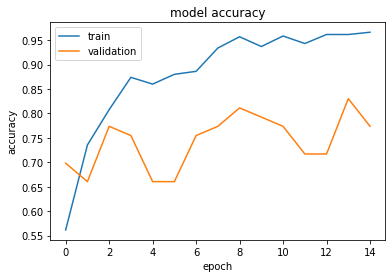

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


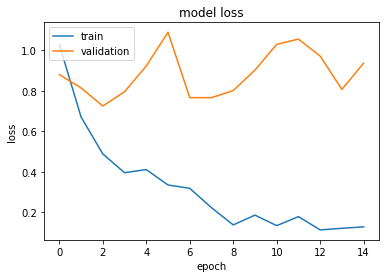

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [38]:
model.save("xcep_new_4l_bi_91_01.h5")

In [32]:
from tensorflow.keras.models import load_model
model = load_model("D:\Capstone Project\Codes\Dataset//xcep_new_4l_bi_87_83.h5")

In [34]:
tes = get_transfer_values("","D:\Capstone Project\Codes\Dataset\explosion_2.mp4")

1/1 [==============================] - 2s 2s/step


In [41]:
class_list =["Accident","Normal","Explosion","Assault"]

In [ ]:
test_result = model.predict(np.array([tes]))

predicted_label = np.argmax(test_result)
predicted_class_name = class_list[predicted_label]
print(test_result)
print(predicted_class_name)

In [39]:
import smtplib
import ssl
from email.message import EmailMessage


email_sender = 'pavan.kusetty9324@gmail.com'
email_password = 'oxgf doxt zzfj bobg'
email_receiver = 'akuthotaprashanth2003@gmail.com'


subject = 'Abnormal Activity detected!'
body = class_list[np.argmax(test_result)]

em = EmailMessage()
em['From'] = email_sender
em['To'] = email_receiver
em['Subject'] = subject
em.set_content(body)


context = ssl.create_default_context()


with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
    smtp.login(email_sender, email_password)
    smtp.sendmail(email_sender, email_receiver, em.as_string())

NameError: name 'test_result' is not defined

In [40]:
def sendmail(pred_class):
    email_sender = 'pavan.kusetty9324@gmail.com'
    email_password = 'oxgf doxt zzfj bobg'
    email_receiver = 'akuthotaprashanth2003@gmail.com'


    subject = 'Abnormal Activity detected!'
    body = pred_class + " is Detected!!"

    em = EmailMessage()
    em['From'] = email_sender
    em['To'] = email_receiver
    em['Subject'] = subject
    em.set_content(body)


    context = ssl.create_default_context()


    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
        smtp.login(email_sender, email_password)
        smtp.sendmail(email_sender, email_receiver, em.as_string())


In [52]:
target_test[2]

array([1., 0., 0., 0.])

In [33]:
pred = model.predict(np.array(data_test))

6/6 [==============================] - 2s 258ms/step


In [34]:
la_te = []
pr_te = []
for i in range(len(data_test)):

    la_te.append(np.argmax(target_test[i]))
    pr_te.append(np.argmax(pred[i]))

Text(0.5, 1.0, 'Confusion Matrix')

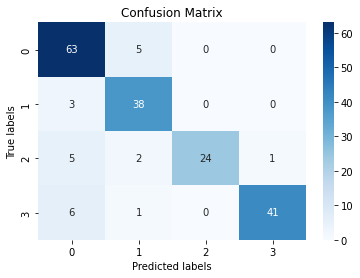

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(la_te, pr_te)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap = "Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [36]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(la_te, pr_te)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        68
           1       0.83      0.93      0.87        41
           2       1.00      0.75      0.86        32
           3       0.98      0.85      0.91        48

    accuracy                           0.88       189
   macro avg       0.91      0.86      0.88       189
weighted avg       0.89      0.88      0.88       189



In [41]:
def detect_violence_realtime(model, sequence_length=_images_per_file):
   
    cap = cv2.VideoCapture(0)

   
    violence_counter = 0
    frames_queue = []
    frame_count = 0
    frame_skip = 10
    
       
    while(True):
            ret, frame = cap.read()

            RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
            res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                    interpolation=cv2.INTER_CUBIC)
            

            frame_count += 1

    
            if frame_count % frame_skip == 0:
                frames_queue.append(res)
                resul = np.array(frames_queue)
                resul = (resul / 255.).astype(np.float16)
                frame_count = 0
                cv2.imshow('Real-time Violence Detection', frame)


        
            if len(frames_queue) == sequence_length:
                        
                frames_array = np.array(frames_queue)
                frames_array = np.expand_dims(frames_array, axis=0)
                shape = (_images_per_file,) + img_size_touple + (3,)
                image_batch = np.zeros(shape=shape, dtype=np.float16)
                image_batch = resul
                shape = (_images_per_file, transfer_values_size)
                t_val = np.zeros(shape=shape, dtype=np.float16)
                t_val = image_model_transfer.predict(image_batch)
                predicted_labels_probabilities = model.predict(np.array([t_val]))
                predicted_label = np.argmax(predicted_labels_probabilities)
                predicted_class_name = class_list[predicted_label]
                print(predicted_class_name)
                if(predicted_class_name != "Normal"):
                    sendmail(predicted_class_name)
                frames_queue = []
            
            

            if cv2.waitKey(1) & 0xFF == ord('q'):
               break



    cap.release()
    cv2.destroyAllWindows()

In [36]:
detect_violence_realtime(model)

1/1 [==============================] - 0s 448ms/step


NameError: name 'class_list' is not defined

: 